## Parte III: Machine Learning
Bautista Boeri - 110898

Enlace a este notebook:https://colab.research.google.com/drive/10JqNrtAdUUQJwnCjpuRGiUQnSo5lZ_uI?usp=sharing

In [ ]:
import pandas as pd
from google.colab import drive
!pip install category_encoders -q
import numpy as np
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb


drive.mount('/content/drive')
# Load the DataFrames from pickle files
tweets_df = pd.read_pickle('/content/drive/MyDrive/tp3/tweets_engineered_features_refactored.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/tp3/test_engineered_features_refactored.pkl')

# Display the first few rows of each DataFrame
print("Tweets DataFrame:")
display(tweets_df.head())

print("\nTest DataFrame:")
display(test_df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.1 MB/s eta 0:00:00
Mounted at /content/drive
Tweets DataFrame:


,id,keyword,location,text,target,cantidad_emoji,cantidad_hashtags,cantidad_arrobas,sentimiento,cantidad_links,tiene_4_simbolos_consecutivos,cantidad_palabras
0,1,sin_keyword,sin_locacion,Our Deeds are the Reason of this #earthquake M...,1,0,1,0,positivo,0,0,13
1,4,sin_keyword,sin_locacion,Forest fire near La Ronge Sask. Canada,1,0,0,0,negativo,0,0,7
2,5,sin_keyword,sin_locacion,All residents asked to 'shelter in place' are ...,1,0,0,0,negativo,0,0,22
3,6,sin_keyword,sin_locacion,"13,000 people receive #wildfires evacuation or...",1,0,1,0,positivo,0,0,8
4,7,sin_keyword,sin_locacion,Just got sent this photo from Ruby #Alaska as ...,1,0,2,0,positivo,0,0,16



Test DataFrame:


,id,keyword,location,text,cantidad_emoji,cantidad_hashtags,cantidad_arrobas,sentimiento,cantidad_links,tiene_4_simbolos_consecutivos,cantidad_palabras
0,0,sin_keyword,sin_locacion,Just happened a terrible car crash,0,0,0,muy negativo,0,0,6
1,2,sin_keyword,sin_locacion,"Heard about #earthquake is different cities, s...",0,1,0,positivo,0,0,9
2,3,sin_keyword,sin_locacion,"there is a forest fire at spot pond, geese are...",0,0,0,muy negativo,0,0,19
3,9,sin_keyword,sin_locacion,Apocalypse lighting. #Spokane #wildfires,0,2,0,positivo,0,0,4
4,11,sin_keyword,sin_locacion,Typhoon Soudelor kills 28 in China and Taiwan,0,0,0,muy negativo,0,0,8


Hacemos casi el mismo proceso de encoding que en la parte 2

In [3]:
tweets_df['keyword'] = tweets_df['keyword'].fillna('sin_keyword')
tweets_df['location'] = tweets_df['location'].fillna('sin_locacion')

test_df['keyword'] = test_df['keyword'].fillna('sin_keyword')
test_df['location'] = test_df['location'].fillna('sin_locacion')

In [4]:
text_features = 'text'

# Features binarias (se mantienen igual)
binary_features = [ 'tiene_4_simbolos_consecutivos']

# Features numéricas (conteos refactorizados)
numeric_features = ['cantidad_emoji', 'cantidad_hashtags', 'cantidad_arrobas', 'cantidad_links', 'cantidad_palabras']

# Features categóricas
onehot_features = ['sentimiento']
binary_encode_features = []
mean_encode_features = ['keyword']

# Todas las features
feature_cols = [text_features] + numeric_features + onehot_features + mean_encode_features + binary_features + binary_encode_features

En este caso, no se utiliza la feature de location pues dio mejores resultados que al usarlo. Esto puede ocurrir pues tal vez no era util o hacia confundir al modelo

In [5]:
X = tweets_df[feature_cols]
y = tweets_df['target']

# X_test_final solo tiene las features
X_test_final = test_df[feature_cols]


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de X_test_final: {X_test_final.shape}")

Forma de X_train: (6090, 9)
Forma de X_val: (1523, 9)
Forma de X_test_final: (3263, 9)


Hacemos encoding como en el baseline

In [6]:
print("Procesando MeanEncoder...")
mean_encoder = ce.TargetEncoder(cols=mean_encode_features)
X_train_mean = mean_encoder.fit_transform(X_train[mean_encode_features], y_train)
X_val_mean = mean_encoder.transform(X_val[mean_encode_features])
X_test_mean = mean_encoder.transform(X_test_final[mean_encode_features])

Procesando MeanEncoder...


In [7]:
print("Procesando BinaryEncoder...")
binary_encoder = ce.BinaryEncoder(cols=binary_encode_features)
X_train_binary = binary_encoder.fit_transform(X_train[binary_encode_features])
X_val_binary = binary_encoder.transform(X_val[binary_encode_features])
X_test_binary = binary_encoder.transform(X_test_final[binary_encode_features])

Procesando BinaryEncoder...


In [8]:
print("Procesando OneHotEncoder...")
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe_encoder.fit_transform(X_train[onehot_features])
X_val_cat = ohe_encoder.transform(X_val[onehot_features])
X_test_cat = ohe_encoder.transform(X_test_final[onehot_features])
# Ponerles nombres a las columnas
ohe_cols = ohe_encoder.get_feature_names_out(onehot_features)
X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=ohe_cols)
X_val_cat_df = pd.DataFrame(X_val_cat, index=X_val.index, columns=ohe_cols)
X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test_final.index, columns=ohe_cols)

Procesando OneHotEncoder...


A diferencia del modelo previo con la regresion. Utilizamos otro encoding mas complejo pero que genera menos features. Utilizando este encoding pudimos obtener mejores resultados. A diferencia del otro embedding, este ya esta pre-entrenado

In [9]:

!pip install sentence-transformers -q
from sentence_transformers import SentenceTransformer

print("Cargando Sentence-BERT...")
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

print("Generando embeddings...")
train_embeddings = sbert_model.encode(X_train[text_features].tolist(), batch_size=32, show_progress_bar=True)
val_embeddings = sbert_model.encode(X_val[text_features].tolist(), batch_size=32, show_progress_bar=True)
test_embeddings = sbert_model.encode(X_test_final[text_features].tolist(), batch_size=32, show_progress_bar=True)
#
embedding_cols = [f'sbert_{i}' for i in range(train_embeddings.shape[1])]
X_train_text_df = pd.DataFrame(train_embeddings, index=X_train.index, columns=embedding_cols)
X_val_text_df = pd.DataFrame(val_embeddings, index=X_val.index, columns=embedding_cols)
X_test_text_df = pd.DataFrame(test_embeddings, index=X_test_final.index, columns=embedding_cols)
print(f"✓ Embeddings: {train_embeddings.shape[1]} dims")


Cargando Sentence-BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generando embeddings...


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

✓ Embeddings: 384 dims


In [10]:
# Normalizar las features numéricas con StandardScaler
print("Normalizando features numéricas...")
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_val_num = scaler.transform(X_val[numeric_features])
X_test_num = scaler.transform(X_test_final[numeric_features])

# Convertir a DataFrames para mantener los índices
X_train_num_df = pd.DataFrame(X_train_num, index=X_train.index, columns=numeric_features)
X_val_num_df = pd.DataFrame(X_val_num, index=X_val.index, columns=numeric_features)
X_test_num_df = pd.DataFrame(X_test_num, index=X_test_final.index, columns=numeric_features)

print("Concatenando todo...")
X_train_final = pd.concat([X_train_text_df,X_train_mean, X_train_cat_df,  X_train_num_df, X_train[binary_features],X_train_binary], axis=1)
X_val_final = pd.concat([X_val_text_df,X_val_mean, X_val_cat_df,  X_val_num_df, X_val[binary_features],X_val_binary], axis=1)
X_test_final_final = pd.concat([X_test_text_df,X_test_mean, X_test_cat_df,  X_test_num_df, X_test_final[binary_features],X_test_binary], axis=1)

Normalizando features numéricas...
Concatenando todo...


## Primer modelo: Random Forest

Primero probaremos de forma manual cambiando los parametros para encontrar unos parametros que se vayan acercando al mejor modelo que podamos hacer. Posterior a esto haremos un gridsearch para probar unas variantes

In [12]:

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    criterion='gini'
)

In [13]:
rf_model.fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, max_samples=0.8,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [15]:
preds = rf_model.predict(X_val_final)
print(mean_squared_error(preds, y_val))
preds

0.16414970453053185


array([0, 0, 1, ..., 1, 0, 0])

In [16]:
score_f1_val = f1_score(y_val, preds)
print(f"\nScore F1 en Validación: {score_f1_val:.4f}")

print("\nReporte de Clasificación en Validación:")
print(classification_report(y_val, preds))


Score F1 en Validación: 0.7971

Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       869
           1       0.85      0.75      0.80       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.83      1523



Hacemos un gridsearch para buscar los mejores parametros del modelo

In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 220],
    'max_depth': [15, 17],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [12, 15],
    'max_features': ['sqrt'],
    'max_samples': [0.8, 0.85]
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    criterion='gini'
)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("Iniciando GridSearchCV")
grid_search.fit(X_train_final, y_train)

print("\n" + "="*60)
print("MEJORES PARÁMETROS ENCONTRADOS:")
print("="*60)
print(grid_search.best_params_)

print(f"\nMejor F1 Score en CV: {grid_search.best_score_:.4f}")

# Evaluar en validación
rf_model2 = grid_search.best_estimator_
preds2 = rf_model2.predict(X_val_final)
f1_val = f1_score(y_val, preds2)

print(f"\n{'='*60}")
print(f"F1 Score en VALIDACIÓN: {f1_val:.4f}")
print(f"{'='*60}\n")
print(classification_report(y_val, preds2))

Iniciando GridSearchCV (32 combinaciones, ~2-5 minutos)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

MEJORES PARÁMETROS ENCONTRADOS:
{'max_depth': 17, 'max_features': 'sqrt', 'max_samples': 0.85, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 220}

Mejor F1 Score en CV: 0.7797

F1 Score en VALIDACIÓN: 0.8039

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       869
           1       0.86      0.76      0.80       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



A partir del gridsearch logramos obtener unos parametros utiles. Ahora utilizaremos estos mejores parametros y los cambiamos un poco para ver si conseguimos un mejor modelo. A continuacion se encuentra el mejor modelo que se consiguio cambiando los parametros a mano en base a lo que se obtuvo en el gridsearch.

In [ ]:

rf_model2 = RandomForestClassifier(
    n_estimators=175,
    max_depth=17,
    min_samples_leaf=5,
    min_samples_split=13,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    criterion='gini'
)

In [ ]:
rf_model2.fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=17, max_samples=0.8,
                       min_samples_leaf=5, min_samples_split=13,
                       n_estimators=175, n_jobs=-1, random_state=42)

In [ ]:
preds2 = rf_model2.predict(X_val_final)
print(mean_squared_error(preds2, y_val))
preds2

0.1582403151674327


array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
score_f1_val = f1_score(y_val, preds2)
print(f"\nScore F1 en Validación: {score_f1_val:.4f}")

print("\nReporte de Clasificación en Validación:")
print(classification_report(y_val, preds2))


Score F1 en Validación: 0.8052

Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       869
           1       0.85      0.76      0.81       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



A partir de una busqueda mas manual, logramos mejorar el score en validacion a partir de lo obtenido en el gridsearch. Se fueron modificando levemente los parametros y validandolo por cada cambio hecho. Despues de varias iteraciones, se llego al resultado previo

Conseguimos las predicciones en los tests y lo subimos al drive

In [ ]:
preds_test= rf_model2.predict(X_test_final_final)
submission_df = pd.DataFrame({'id': test_df['id'], 'target': preds_test})
submission_df.to_csv('submission_part3RF.csv', index=False)
print("Submission file 'submission_part3RF.csv' created successfully!")

Submission file 'submission_part3RF.csv' created successfully!


In [ ]:
import os
import shutil

drive_path = '/content/drive/MyDrive/tp3/'
test_results_dir = os.path.join(drive_path, 'test_results')

# Create the test_results directory if it doesn't exist
if not os.path.exists(test_results_dir):
    os.makedirs(test_results_dir)
    print(f"Created directory: {test_results_dir}")
else:
    print(f"Directory already exists: {test_results_dir}")

# Move submission_part4.csv to the test_results directory
source_path = 'submission_part3RF.csv'
destination_path = os.path.join(test_results_dir, 'submission_part3RF.csv')

shutil.move(source_path, destination_path)
print(f"'submission_part3RF.csv' moved to '{destination_path}' successfully!")

Directory already exists: /content/drive/MyDrive/tp3/test_results
'submission_part3RF.csv' moved to '/content/drive/MyDrive/tp3/test_results/submission_part3RF.csv' successfully!


## Segundo modelo: XGB

Utilizamos el mismo encoding que utilizamos para el modelo previo

Hacemos un procedimiento parecido. Buscamos de forma casera algunos parametros que se acerquen a un f1 score medianamente elevado y despues buscaremos una base con un gridsearch y a partir de este buscaremos lo mejor modificando levemente los parametros

In [19]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)


xgb_model.fit(X_train_final, y_train)

preds=xgb_model.predict(X_val_final)
print(f"F1 Score XGBoost : {f1_score(y_val, preds):.4f}")

F1 Score XGBoost : 0.7987


In [ ]:
param_grid_xgb = {
    'n_estimators': [300, 320],
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.85],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}

print("XGBoost parameter grid defined successfully.")

XGBoost parameter grid defined successfully.


In [ ]:
xgb_base = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss' # Consistent with previous XGBoost model
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("Iniciando GridSearchCV para XGBoost...")
grid_search_xgb.fit(X_train_final, y_train)

print("\n" + "="*60)
print("MEJORES PARÁMETROS ENCONTRADOS (XGBoost):")
print("="*60)
print(grid_search_xgb.best_params_)

print(f"\nMejor F1 Score en CV (XGBoost): {grid_search_xgb.best_score_:.4f}")

Iniciando GridSearchCV para XGBoost...
Fitting 3 folds for each of 64 candidates, totalling 192 fits

MEJORES PARÁMETROS ENCONTRADOS (XGBoost):
{'colsample_bytree': 0.85, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

Mejor F1 Score en CV (XGBoost): 0.7879


In [18]:
xgb_model2 = xgb.XGBClassifier(
    n_estimators=312,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)


xgb_model2.fit(X_train_final, y_train)

preds2=xgb_model2.predict(X_val_final)
print(f"F1 Score XGBoost : {f1_score(y_val, preds):.4f}")

F1 Score XGBoost : 0.7971


In [ ]:
preds_test2= xgb_model2.predict(X_test_final_final)
submission_df = pd.DataFrame({'id': test_df['id'], 'target': preds_test})
submission_df.to_csv('submission_part3XGB.csv', index=False)
print("Submission file 'submission_part3XGB.csv' created successfully!")

Submission file 'submission_part3XGB.csv' created successfully!


Guardamos las predicciones de este modelo en el drive

In [ ]:
import os
import shutil

drive_path = '/content/drive/MyDrive/tp3/'
test_results_dir = os.path.join(drive_path, 'test_results')

# Create the test_results directory if it doesn't exist
if not os.path.exists(test_results_dir):
    os.makedirs(test_results_dir)
    print(f"Created directory: {test_results_dir}")
else:
    print(f"Directory already exists: {test_results_dir}")

# Move submission_part4.csv to the test_results directory
source_path = 'submission_part3XGB.csv'
destination_path = os.path.join(test_results_dir, 'submission_part3XGB.csv')

shutil.move(source_path, destination_path)
print(f"'submission_part3XGB.csv' moved to '{destination_path}' successfully!")

Directory already exists: /content/drive/MyDrive/tp3/test_results
'submission_part3XGB.csv' moved to '/content/drive/MyDrive/tp3/test_results/submission_part3XGB.csv' successfully!


## Cual es el mejor modelo?

Ambos modelos tienen un score en validacion parecido. Podriamos ver la matriz de confusion de los modelos para ver en que se equivoca cada modelo:

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

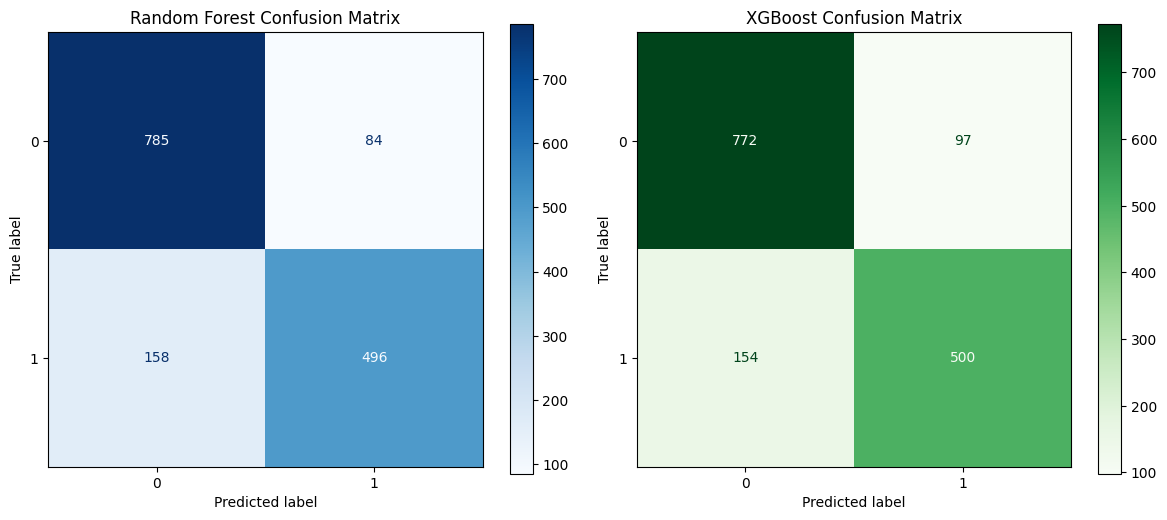

Confusion matrices plotted successfully.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_val, preds2)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Random Forest Confusion Matrix')

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_val, preds)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(ax=axes[1], cmap=plt.cm.Greens)
axes[1].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()



## Análisis y Comparación de Modelos

### 1. Hallazgos Clave

| Métrica | Random Forest (RF) | XGBoost | Comparación (RF vs XGBoost) |
| :--- | :--- | :--- | :--- |
| **Verdaderos Positivos (TP)** | 496 | 500 | XGBoost identificó 4 desastres más. |
| **Verdaderos Negativos (TN)** | 785 | 772 | RF identificó 13 no-desastres más. |
| **Falsos Positivos (FP)** | **84** | 97 | **RF tiene 13 Falsos Positivos menos (Mejor Precisión).** |
| **Falsos Negativos (FN)** | 158 | **154** | XGBoost falló en 4 desastres menos (Mejor Recall). |
| **F1-Score (Validación)** | **0.8052** | 0.7994 | RF es marginalmente superior. |

---
### 2. Conclusión

El modelo **Random Forest** (con un F1-score de 0.8052) es marginalmente mejor para esta tarea de clasificación específica, debido a su mejor balance general de error.

* **Random Forest** ofrece una mejor **Precisión** al reducir las **Falsas Alarmas (FP: 84)**.
* **XGBoost** ofrece un mejor **Recall** al reducir los **Falsos Negativos (FN: 154)**. Si la prioridad absoluta es identificar la mayor cantidad de desastres, XGBoost sería preferible.

Dado que **Random Forest** tiene un F1-score ligeramente superior y significativamente menos Falsos Positivos, se lo considera el mejor modelo para la predicción general con esta configuración. Es mas importante tener menos falsos positivos que falsos negativos en lineas generales. En este caso aunque estemos hablando de tweets, podrian servir de informacion igualmente

##Resultados del modelo de Random Forest:

En kaggle se obtuvo: Score: 0.81826

Notemos que obtuvimos un mejor score que la parte 2 lo cual es algo positivo pero esperado, pues no solo son modelos mas complejos, sino que usamos un embedding mas "inteligente"